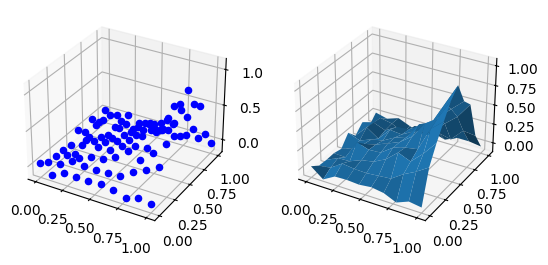

In [58]:
import numpy as np
import matplotlib.pyplot as plt

points = np.load('points.npy')

X = points[:, 0].reshape(10, 10)
Y = points[:, 1].reshape(10, 10)
Z = points[:, 2].reshape(10, 10)

Z /= np.max(Z)

# Paramètres du bruit
noise_level = 0.05  # Amplitude du bruit (5% du signal)

# Génération du bruit gaussien
noise = noise_level * np.random.randn(*Z.shape)

# Ajout du bruit aux valeurs de Z
Z_noisy = Z + noise

fig, axs = plt.subplots(1, 2, subplot_kw={'projection': '3d'})

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        axs[0].scatter(X[i, j], Y[i, j], Z_noisy[i, j], color='b')


axs[1].plot_surface(X, Y, Z_noisy)
plt.show()

In [59]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_tensor = torch.tensor(X.flatten(), dtype=torch.float32, requires_grad=True).view(-1, 1)
Y_tensor = torch.tensor(Y.flatten(), dtype=torch.float32, requires_grad=True).view(-1, 1)
Z_tensor = torch.tensor(Z_noisy.flatten(), dtype=torch.float32).view(-1, 1)  # Pas besoin de grad pour Z


dataset = TensorDataset(X_tensor, Y_tensor, Z_tensor)   
loader = DataLoader(dataset, shuffle=True)


In [60]:
import torch
import torch.nn as nn

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(2, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x, y):
        inputs = torch.cat([x, y], dim=1) 
        return self.layers(inputs)

# CL : nulles aux bords sauf en x=1
from mpl_toolkits.mplot3d import Axes3D
import torch.nn.functional as F

def loss_data(z, pred):
    return F.mse_loss(pred, z)

def loss_laplace(x, y, pred):
    df_dx = torch.autograd.grad(pred, x, grad_outputs=torch.ones_like(pred), create_graph=True, retain_graph=True)[0]
    d2f_dx2 = torch.autograd.grad(df_dx, x, grad_outputs=torch.ones_like(df_dx), create_graph=True, retain_graph=True)[0]

    df_dy = torch.autograd.grad(pred, y, grad_outputs=torch.ones_like(pred), create_graph=True, retain_graph=True)[0]
    d2f_dy2 = torch.autograd.grad(df_dy, y, grad_outputs=torch.ones_like(df_dy), create_graph=True, retain_graph=True)[0]

    return torch.mean((d2f_dx2 + d2f_dy2) ** 2)


def total_loss(x, y, z, pred, L_data=1.0, L_laplace=1.0):
    return L_data * loss_data(z, pred) + L_laplace * loss_laplace(x, y, pred)





Epoch 0, Loss: 4.7509294077026425
Epoch 100, Loss: 0.29346270183100387
✅ Entraînement terminé !


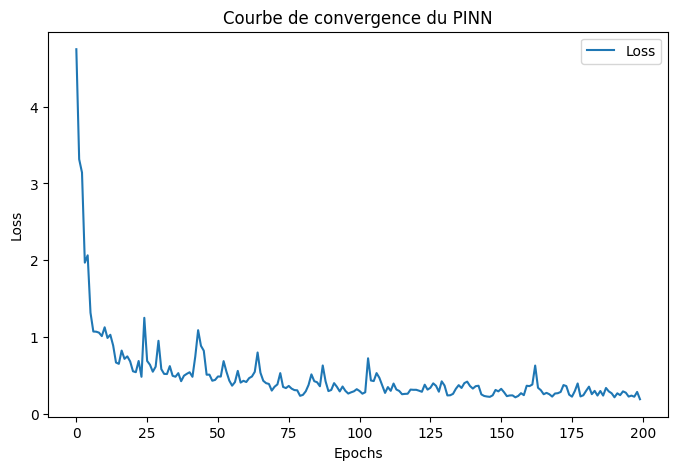

model saved


In [61]:
import torch.optim as optim

def train_and_evaluate(model, loader, num_epochs, learning_rate, device):

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    losses = []    
    
    for epoch in range(num_epochs):
        loss_epoch = 0.0
        for X_batch, Y_batch, Z_batch in loader:

            X_batch = X_batch.to(device).requires_grad_()
            Y_batch = Y_batch.to(device).requires_grad_()
            Z_batch = Z_batch.to(device)

            optimizer.zero_grad()

            #  Prédiction du modèle f(x, y)
            pred = model(X_batch, Y_batch)

            #  Calcul de la perte totale
            loss = total_loss(X_batch, Y_batch, Z_batch, pred, L_data=1, L_laplace=1)
            loss_epoch += loss.item()

            #  Backpropagation et mise à jour des poids
            loss.backward()
            optimizer.step()

        losses.append(np.mean(loss_epoch))

        #  Affichage de la loss toutes les 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss_epoch}")
        
        
    print("✅ Entraînement terminé !")

    #  Affichage de la courbe de perte
    plt.figure(figsize=(8,5))
    plt.plot(losses, label="Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Courbe de convergence du PINN")
    plt.legend()
    plt.show()
    
    # ---- Save the model ----
    torch.save(model, "PINN_noise.pt")
    print("model saved")

model = PINN()
device = "cuda" if torch.cuda.is_available() else "cpu"
train_and_evaluate(model, loader, num_epochs=200, learning_rate=0.001, device=device)

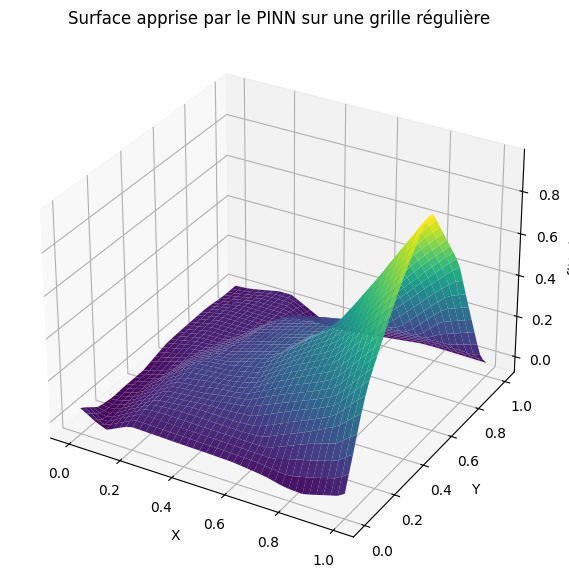

In [62]:
def plot_pinn_solution(model):
    """
    Visualise la surface prédite par le PINN sur une grille régulière.
    """
    model.eval()  # Mode évaluation

    # 🔹 Création d'une grille régulière
    x = np.linspace(0, 1, 40)
    y = np.linspace(0, 1, 40)
    X, Y = np.meshgrid(x, y)

    # 🔹 Conversion en tensors PyTorch
    X_tensor = torch.tensor(X.ravel(), dtype=torch.float32).view(-1, 1)
    Y_tensor = torch.tensor(Y.ravel(), dtype=torch.float32).view(-1, 1)

    # 🔹 Prédiction du modèle sans calcul de gradients
    with torch.no_grad():
        Z_pred = model(X_tensor, Y_tensor).cpu().numpy().reshape(X.shape)

    # 🔹 Tracé de la surface 3D
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z_pred, cmap='viridis', edgecolor='none')

    # Labels et titre
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("f(X,Y)")
    ax.set_title("Surface apprise par le PINN sur une grille régulière")
    plt.show()

model_noise = torch.load("PINN_noise.pt", weights_only=False)
plot_pinn_solution(model_noise)

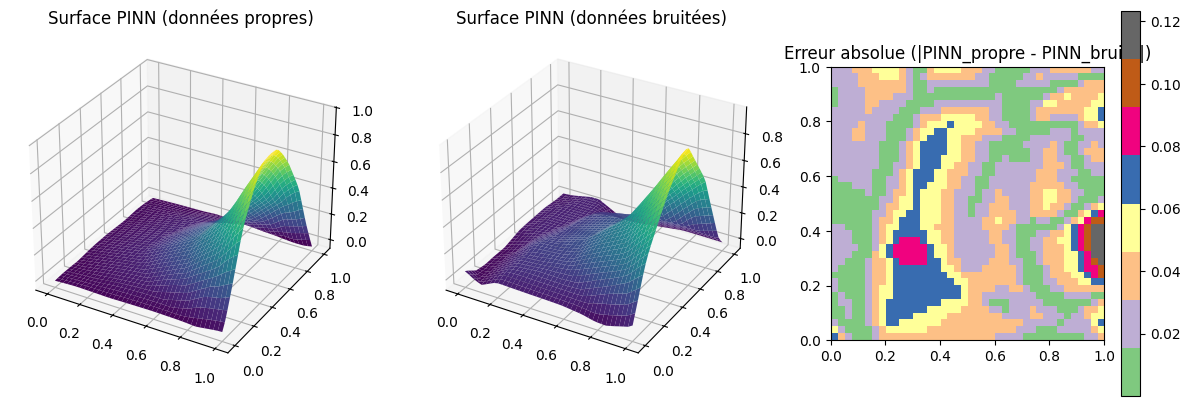

In [66]:
def compare_pinn_results(model_clean, model_noisy):
    """
    Compare les surfaces obtenues avec et sans bruit.
    """
    model_clean.eval()
    model_noisy.eval()

    # 🔹 Création d'une grille régulière
    x = np.linspace(0, 1, 40)
    y = np.linspace(0, 1, 40)
    X, Y = np.meshgrid(x, y)

    # 🔹 Conversion en tensors PyTorch
    X_tensor = torch.tensor(X.ravel(), dtype=torch.float32).view(-1, 1)
    Y_tensor = torch.tensor(Y.ravel(), dtype=torch.float32).view(-1, 1)
    
    with torch.no_grad():
        Z_clean_pred = model_clean(X_tensor, Y_tensor).cpu().numpy().reshape(40, 40)
        Z_noisy_pred = model_noisy(X_tensor, Y_tensor).cpu().numpy().reshape(40, 40)

    # 🔹 Calcul de l'erreur absolue
    error = np.abs(Z_clean_pred - Z_noisy_pred)

    # 🔹 Tracé des résultats
    fig = plt.figure(figsize=(15, 5))

    # 🔸 Surface PINN sans bruit
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot_surface(X_tensor.numpy().reshape(40, 40), Y_tensor.numpy().reshape(40, 40), Z_clean_pred, cmap='viridis')
    ax1.set_title("Surface PINN (données propres)")

    # 🔸 Surface PINN avec bruit
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot_surface(X_tensor.numpy().reshape(40, 40), Y_tensor.numpy().reshape(40, 40), Z_noisy_pred, cmap='viridis')
    ax2.set_title("Surface PINN (données bruitées)")

    # 🔸 Erreur absolue entre les deux surfaces
    ax3 = fig.add_subplot(133)
    c = ax3.imshow(error, cmap='Accent', extent=[0,1,0,1], origin='lower')
    fig.colorbar(c, ax=ax3)
    ax3.set_title("Erreur absolue (|PINN_propre - PINN_bruité|)")

    plt.show()

model_no_noise = torch.load("PINN.pt", weights_only=False)
model_noise = torch.load("PINN_noise.pt", weights_only=False)

compare_pinn_results(model_clean=model_no_noise, model_noisy=model_noise)